In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display


In [2]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file("facades.tar.gz", origin=_URL, extract=True)



30171136/30168306 [==============================] - 7s 0us/step


In [10]:
train_images_folder = os.path.join(os.path.dirname(path_to_zip), "facades", "train")
val_images_folder = os.path.join(os.path.dirname(path_to_zip), "facades", "val")
test_images_folder = os.path.join(os.path.dirname(path_to_zip), "facades", "test")

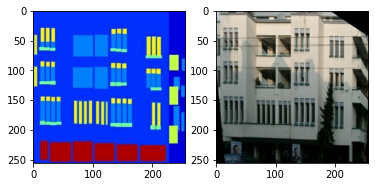

In [148]:
def load_image(file_location):
    file_content = tf.io.read_file(file_location)
    big_image = tf.io.decode_jpeg(file_content)
    big_image_width = tf.shape(big_image)[1]
    half_image_width = big_image_width//2
    sketch = big_image[:, half_image_width:, :]
    g_truth = big_image[:, :half_image_width, :]

    sketch = tf.cast(sketch, tf.float32)
    g_truth = tf.cast(g_truth, tf.float32)
    
    sketch = sketch / 256
    g_truth = g_truth / 256
    
    return sketch, g_truth

sketch, g_truth = load_image(train_images_folder + "\\1.jpg")

plt.subplot(1, 2, 1)
plt.imshow(sketch)

plt.subplot(1, 2, 2)
plt.imshow(g_truth)

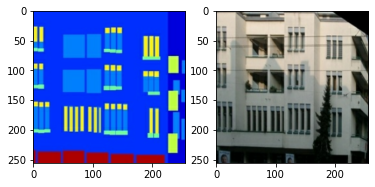

In [127]:
def scale_and_random_crop(sketch, g_truth):
    
    _stack = tf.stack([sketch, g_truth])
    _stack = tf.image.resize(_stack, [280, 280])
    _stack = tf.image.random_crop(_stack, [2, 256, 256, 3])

    sketch = _stack[0]
    g_truth = _stack[1]
    
    return sketch, g_truth

sketch, g_truth = scale_and_random_crop(sketch, g_truth)

plt.subplot(1, 2, 1)
plt.imshow(sketch)

plt.subplot(1, 2, 2)
plt.imshow(g_truth)

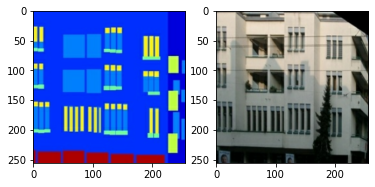

In [128]:
def random_flip(sketch, g_truth):
    _stack = tf.stack([sketch, g_truth])
    
    if(tf.random.uniform([1]) > 0.5):
        _stack = tf.image.flip_left_right(_stack)

    return _stack[0], _stack[1]

sketch, g_truth = random_flip(sketch, g_truth)

plt.subplot(1, 2, 1)
plt.imshow(sketch)

plt.subplot(1, 2, 2)
plt.imshow(g_truth)

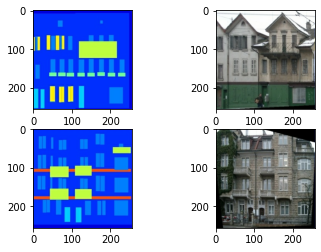

In [264]:
def image_preprocessing(image_file):
    sketch, g_truth = load_image(image_file)
    return sketch, g_truth

def build_dataset(folder):
    ds = tf.data.Dataset.list_files(os.path.join(folder, "*.jpg"))
    ds = ds.map(image_preprocessing)
    ds = ds.batch(1)
    return ds

NUMBER_OF_BATCHES = 2
train_ds = build_dataset(train_images_folder)
val_ds = build_dataset(val_images_folder)

for idx, (sketch, g_truth) in enumerate(train_ds.take(NUMBER_OF_BATCHES)):
    plt.subplot(NUMBER_OF_BATCHES, 2, (idx * 2) + 1)
    plt.imshow(sketch[0])
    plt.subplot(NUMBER_OF_BATCHES, 2, (idx * 2) + 2)
    plt.imshow(g_truth[0])
    

--- Generator

In [163]:
def generator_downsample(filters, size, apply_batchnorm = True):
    model = tf.keras.models.Sequential()
    model.add(
        tf.keras.layers.Conv2D(filters, kernel_size=size, strides=2, padding="same")
    )
    if(apply_batchnorm):
        model.add(
            tf.keras.layers.BatchNormalization()
        )
    model.add(
        tf.keras.layers.LeakyReLU()
    )
    return model

def generator_upsample(filters, size, apply_dropout = False):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2DTranspose(filters, kernel_size=size, strides=2, padding="same")
    )
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    if(apply_dropout):
        model.add(
            tf.keras.layers.Dropout(0.5)
        )
    model.add(
        tf.keras.layers.ReLU()
    )
    return model


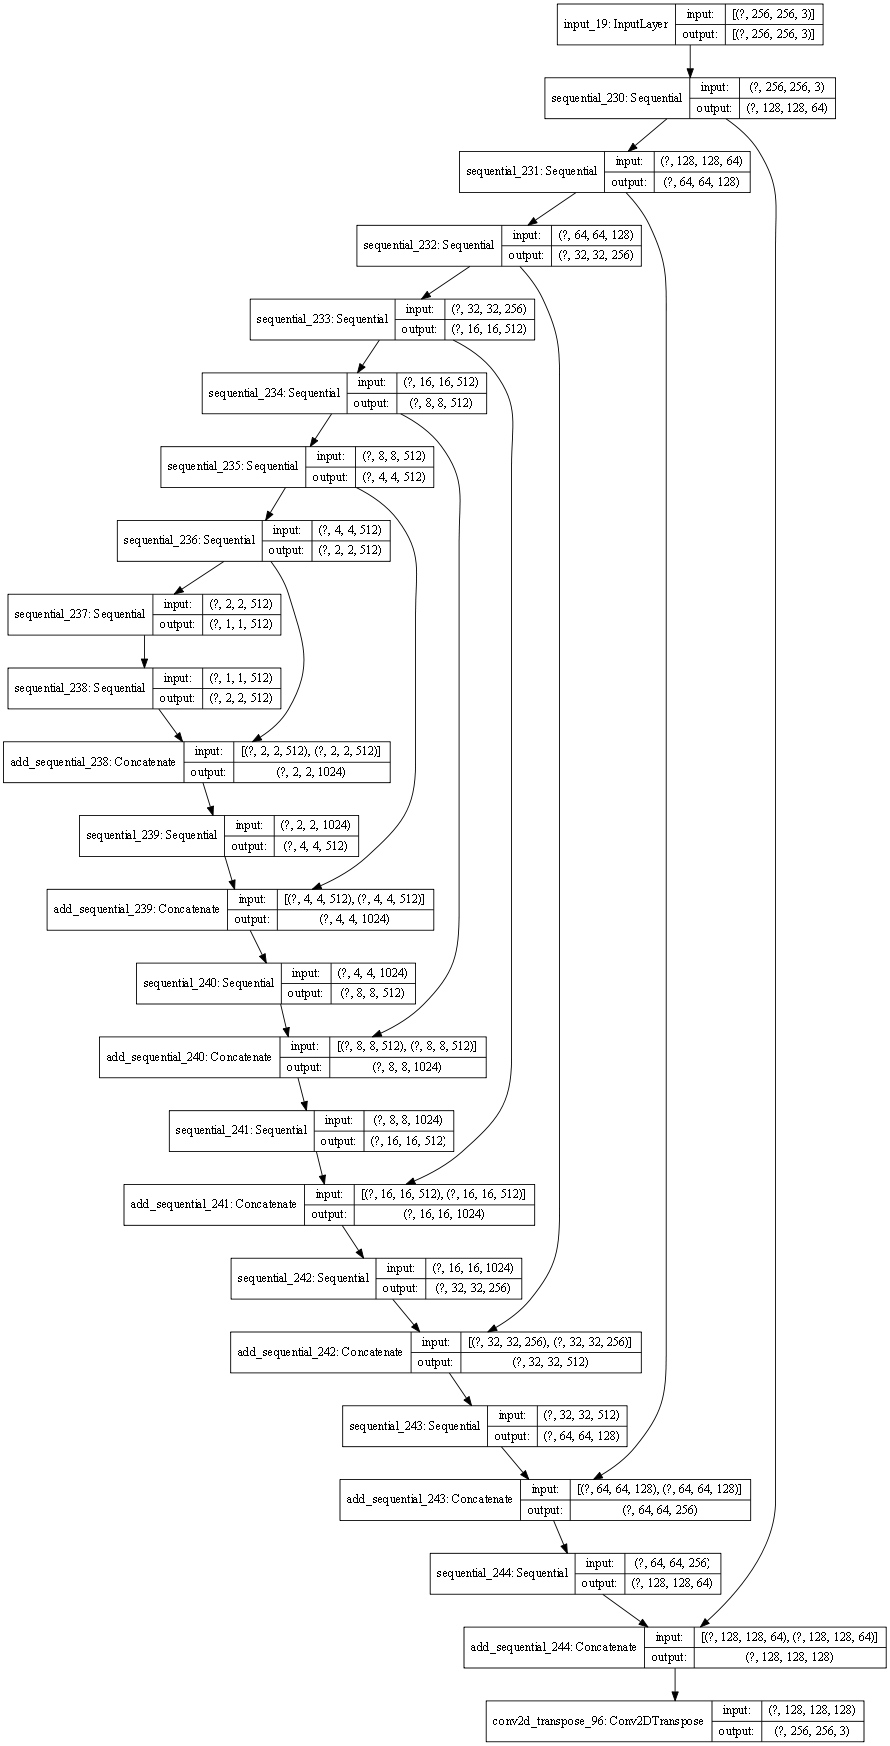

In [193]:
def build_generator():
    downsample_steps = [
        generator_downsample(64, 4, apply_batchnorm=False), # (?, 128, 128, 64)
        generator_downsample(128, 4), # (?, 64, 64, 128)
        generator_downsample(256, 4), # (?, 32, 32, 256)
        generator_downsample(512, 4), # (?, 16, 16, 512)
        generator_downsample(512, 4), # (?, 8, 8, 512)
        generator_downsample(512, 4), # (?, 4, 4, 512)
        generator_downsample(512, 4), # (?, 2, 2, 512)
        generator_downsample(512, 4), # (?, 1, 1, 512)
    ]

    upsample_steps = [
        generator_upsample(512, 4, apply_dropout=True), # (?, 2, 2, 512)
        generator_upsample(512, 4, apply_dropout=True), # (?, 4, 4, 512)
        generator_upsample(512, 4, apply_dropout=True), # (?, 8, 8, 512)
        generator_upsample(512, 4), # (?, 16, 16, 512)
        generator_upsample(256, 4), # (?, 32, 32, 256)
        generator_upsample(128, 4), # (?, 64, 64, 128)
        generator_upsample(64, 4), # (?, 128, 128, 64)
    ]

    inputs = tf.keras.layers.Input(shape = [256, 256, 3])

    x = inputs
    generator_steps_otput = []
    for step in downsample_steps:
        x = step(x)
        generator_steps_otput.append(x)

    skip_conns = reversed(generator_steps_otput[:-1])
    for step, skip_conn in zip(upsample_steps, skip_conns):
        x = step(x)
        x = tf.keras.layers.Concatenate(name = "add_" + step.name)([x, skip_conn])

    output_layer = tf.keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same")(x)

    return tf.keras.models.Model(inputs=[inputs], outputs = [output_layer])

generator = build_generator()

tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

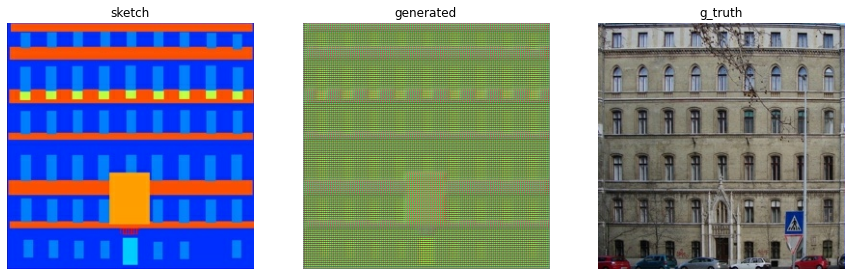

In [257]:
def plot_3_images(model, sketch, g_truth):
    generated = model(sketch)

    def normalize(img):
        img = img - tf.reduce_min(img)
        return img / tf.reduce_max(img)

    plt.figure(figsize=(15, 15))
    plt.subplot(1,3,1)
    plt.title("sketch")
    plt.imshow(sketch[0])
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.title("generated")
    plt.imshow(normalize(generated[0]))
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.title("g_truth")
    plt.imshow(g_truth[0])
    plt.axis("off")

sketch, g_truth = next(iter(train_ds))
plot_3_images(generator, sketch, g_truth)

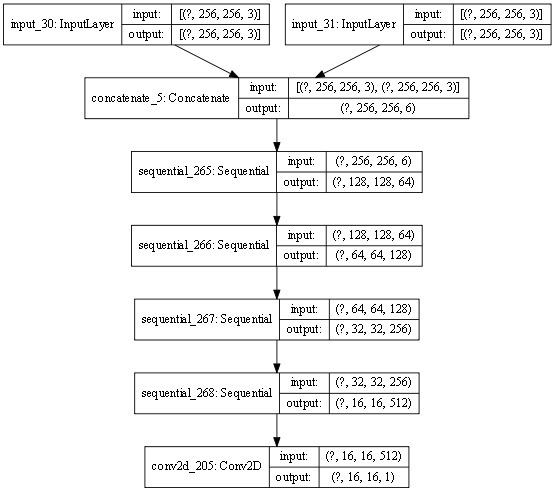

In [232]:
def build_discriminator():
    steps = [
        generator_downsample(64, 4), # (?, 128, 128, 64)
        generator_downsample(128, 4), # (?, 64, 64, 128)
        generator_downsample(256, 4), # (?, 32, 32, 256)
        generator_downsample(512, 4), # (?, 16, 16, 512)
    ]
    
    sketch = tf.keras.layers.Input(shape = [256, 256, 3])
    target_image = tf.keras.layers.Input(shape = [256, 256, 3])

    x = tf.keras.layers.Concatenate()([sketch, target_image])
    for step in steps:
        x = step(x)        

    x = tf.keras.layers.Conv2D(1, kernel_size=4, strides = 1, padding = "same")(x)

    return tf.keras.Model(inputs = [sketch, target_image], outputs=[x])

discriminator = build_discriminator()

tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

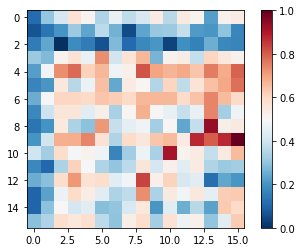

In [241]:
disc_out = discriminator([sketch, generated])
plt.imshow(normalize(disc_out[0]), cmap="RdBu_r")
plt.colorbar()

In [252]:
loss_object = tf.keras.losses.BinaryCrossentropy()

LAMBDA = 100

def generator_loss(generated_img):
    target = tf.ones_like(generated_img)
    gan_loss = loss_object(target, generated_img)
    
    l1_loss = tf.reduce_mean(tf.abs(generated_img - target))
    
    return gan_loss + LAMBDA * l1_loss, gan_loss, l1_loss

generator_loss(generated)

(<tf.Tensor: shape=(), dtype=float32, numpy=111.976685>,
 <tf.Tensor: shape=(), dtype=float32, numpy=11.279951>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0069673>)

In [258]:
def discriminator_loss(generated_img, g_truth_img):
    generated_loss = loss_object(tf.zeros_like(generated_img), generated_img)
    g_truth_loss = loss_object(tf.ones_like(g_truth_img), g_truth_img)
    
    return generated_loss + g_truth_loss


In [259]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()


In [260]:
def make_step(sketch, g_truth):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_img = generator(sketch, training=True)
        
        disc_generated_output = discriminator([sketch, generated_img], training=True)
        disc_gtruth_output    = discriminator([sketch, g_truth], training=True)

        generator_loss_total, generarator_loss_gan, generarator_loss_l1 = generator_loss(generated_img)
        disc_loss = discriminator_loss(disc_generated_output, disc_gtruth_output)
        
    generator_gradients = gen_tape.gradient(generator_loss_total, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    
    
    

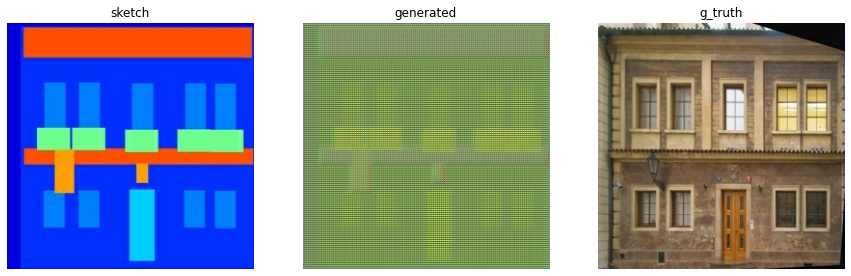

Epoch: 0
.

In [ ]:
EPOCHS = 150

def fit(train_ds, val_ds):
    for epoch in range(EPOCHS):
        epoch_start = time.time()
        
        val_sketch, val_gtruth = next(iter(val_ds))
        plot_3_images(generator, val_sketch, val_gtruth)
        plt.show()
        
        print("Epoch:", epoch)
        
        for idx, (sketch, g_truth) in enumerate(train_ds):
            if(idx % 100 == 0):
                print(".", end="")
                
            make_step(sketch, g_truth)
            
        print()
        print("epoch", epoch, "duration:", time.time() - epoch_start, "sec")
            
fit(train_ds, val_ds)